In [1]:
using FourierFlows
using LinearAlgebra: ldiv!, mul!

In [2]:
function rms(field1, field2, grid)
    return sqrt.(sum(field1.^2 + field2.^2)/grid.nx/grid.ny)
end

function rms(field, grid)
    return sqrt.(sum(field.^2)/grid.nx/grid.ny)
end

function set_shafer_initial_condition!(grid, Kg, Kw, ag, aw, f, Cg2)

    dev = typeof(grid.device)
    T = typeof(grid.Lx)

    @devzeros dev Complex{T} (grid.nkr, grid.nl) ugh vgh ηgh uwh vwh ηwh
    @devzeros dev T (grid.nx, grid.ny) ug uw vg vw ζ
    
    geo_filter  = (Kg[1]^2 .<= grid.Krsq .<= Kg[2]^2) .& (grid.Krsq .> 0)
    wave_filter = (Kw[1]^2 .<= grid.Krsq .<= Kw[2]^2) .& (grid.Krsq .> 0)
    phase = device_array(grid.device)(2π*rand(grid.nkr, grid.nl))
    sgn =  device_array(grid.device)(sign.(rand(grid.nkr, grid.nl) .- 0.5))
    shift = exp.(1im * phase)
    ω = sqrt.(f^2 .+ Cg2 * grid.Krsq)
    geo_amp_factor  = 1 ./ ω .* (grid.invKrsq).^(3/4)
    wave_amp_factor = sqrt.(grid.invKrsq) ./ (2 * ω) .* (grid.invKrsq).^(1/4)
    ηgh[geo_filter] += ( geo_amp_factor  * f .* shift)[geo_filter]
    ugh[geo_filter] += (-geo_amp_factor  * 1im * Cg2 .* grid.l  .* shift)[geo_filter]
    vgh[geo_filter] += ( geo_amp_factor  * 1im * Cg2 .* grid.kr .* shift)[geo_filter]

    ldiv!(ug, grid.rfftplan, deepcopy(ugh))
    ldiv!(vg, grid.rfftplan, deepcopy(vgh))
    ζh = 1im * grid.kr .* vgh - 1im * grid.l .* ugh
    ldiv!(ζ, grid.rfftplan, deepcopy(ζh))
    
    ηgh .*= ag / rms(ug, vg, grid)
    ugh .*= ag / rms(ug, vg, grid)
    vgh .*= ag / rms(ug, vg, grid)

    ηwh[wave_filter] += (wave_amp_factor .* grid.Krsq .* shift)[wave_filter]
    uwh[wave_filter] += (wave_amp_factor .* (sgn .* grid.kr .* ω .* shift + 1im * f * grid.l  .* shift))[wave_filter]
    vwh[wave_filter] += (wave_amp_factor .* (sgn .* grid.l  .* ω .* shift - 1im * f * grid.kr .* shift))[wave_filter]
    
    ldiv!(uw, grid.rfftplan, deepcopy(uwh))
    ldiv!(vw, grid.rfftplan, deepcopy(vwh))
    ζh = 1im * grid.kr .* vwh - 1im * grid.l .* uwh
    ldiv!(ζ, grid.rfftplan, deepcopy(ζh))
    
    ηwh .*= aw / rms(uw, vw, grid)
    uwh .*= aw / rms(uw, vw, grid)
    vwh .*= aw / rms(uw, vw, grid)
    return (ugh, vgh, ηgh), (uwh, vwh, ηwh)
end

set_shafer_initial_condition! (generic function with 1 method)

In [3]:
grid = TwoDGrid(; Lx=2π, nx=256)
f = 3.0
Cg = 1.0
Kg2 = 13
Kw = 5
(ugh, vgh, ηgh), (uwh, vwh, ηwh) = set_shafer_initial_condition!(grid, (Kg2-3, Kg2), (Kw-5, Kw), 0.05, 0.1, f, Cg^2)
divgh = 1im * grid.kr .* ugh + 1im * grid.l .* vgh
divwh = 1im * grid.kr .* uwh + 1im * grid.l .* vwh
qgh = 1im * grid.kr .* vgh - 1im * grid.l .* ugh - f * ηgh
qwh = 1im * grid.kr .* vwh - 1im * grid.l .* uwh - f * ηwh
println(maximum(abs.(divgh)))
println(maximum(abs.(qwh)))

3.2155493553843715e-13
3.410605131648481e-13


RMS Ug:      0.05
RMS Uw:      0.1
RMS Fr:      0.05
RMS Ro:      0.19662657619806176
Max ζ Ro:    0.6524091158698713
Max Fr:      0.14163324154739898
Factor:      4.606327644146562
Theo factor: 4.333333333333333


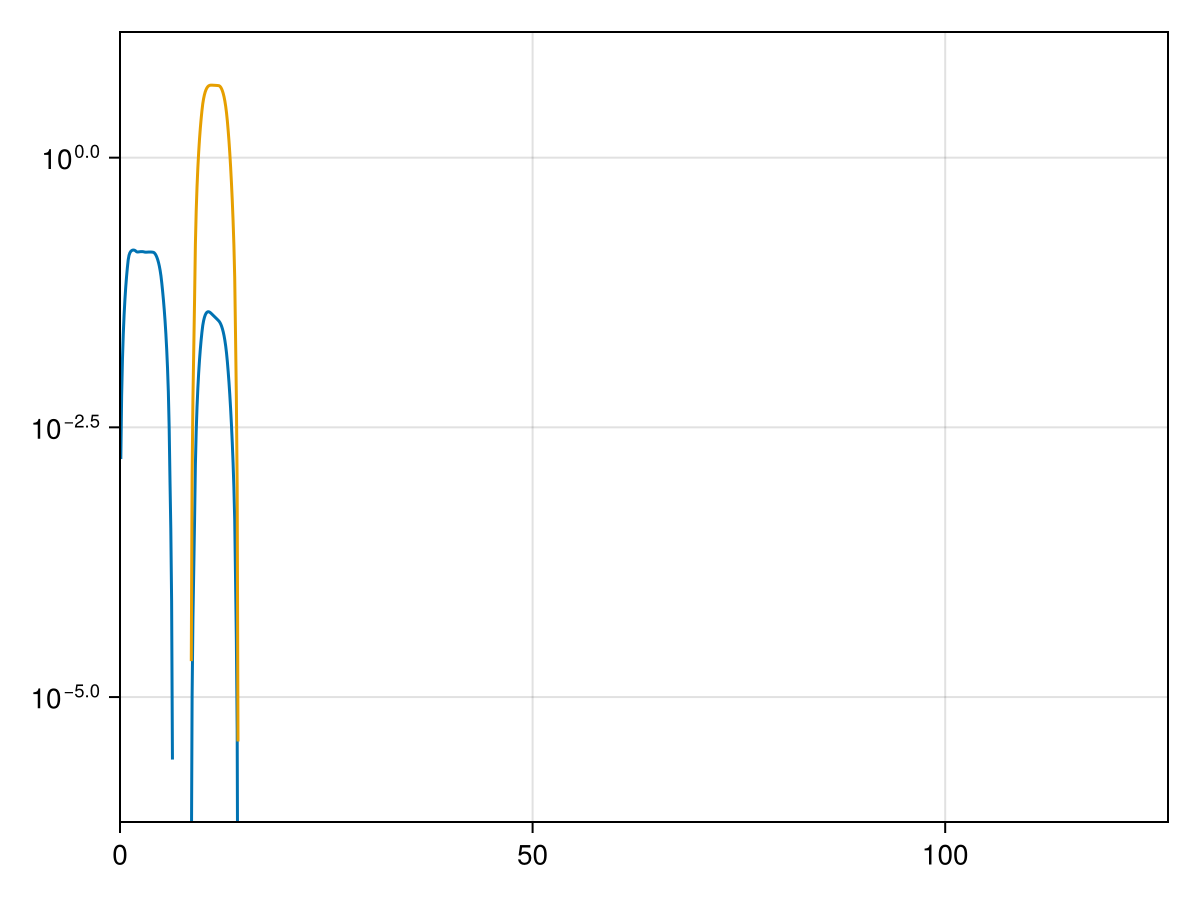

In [8]:
using CairoMakie
using AbstractFFTs
include("../utils/ExactRadialSpectrum.jl")

#ρ, weights = create_radialspectrum_weights(grid, 5)

uh = ugh + uwh
vh = vgh + vwh
ηh = ηgh + ηwh

PV = 1im * grid.kr .* vh - 1im * grid.l .* uh - f * ηh
Enstrophy = abs2.(PV)
Energy = abs2.(uh) + abs2.(vh) + Cg^2*abs2.(ηh)

Emax = FourierFlows.parsevalsum(Energy, grid)
ρ, Ehr = FourierFlows.radialspectrum(Energy, grid, refinement=5)
Ehr *= grid.Lx^2/grid.nx^4

Zmax = FourierFlows.parsevalsum(Enstrophy, grid)
ρ, Zhr = FourierFlows.radialspectrum(Enstrophy, grid, refinement=5)
Zhr *= grid.Lx^2/grid.nx^4

fig = Figure()
ax = Axis(fig[1,1]; yscale=log10, limits=((ρ[1], ρ[end]), (1e-6*min(Emax, Zmax), max(Emax, Zmax))))
lines!(ax, ρ, replace!(Ehr[:], 0.0=>NaN))
lines!(ax, ρ, replace!(Zhr[:], 0.0=>NaN))


ζh = @. 1im * grid.kr * vh - 1im * grid.l * uh
ζ = irfft(ζh, grid.nx)
ug = irfft(ugh, grid.nx)
vg = irfft(vgh, grid.nx)
Ug = @. sqrt(ug^2 + vg^2)
uw = irfft(uwh, grid.nx)
vw = irfft(vwh, grid.nx)
Uw = @. sqrt(uw^2 + vw^2)
println("RMS Ug:      ", rms(Ug, grid))
println("RMS Uw:      ", rms(Uw, grid))
println("RMS Fr:      ", rms(Ug, grid)/Cg)
println("RMS Ro:      ", rms(ζ, grid)/f)
println("Max ζ Ro:    ", maximum(ζ)/f)
println("Max Fr:      ", maximum(Ug)/Cg)
println("Factor:      ", (maximum(ζ)/f)/(maximum(Ug)/Cg))
println("Theo factor: ", Kg2/(f/Cg))

fig

In [5]:
abs2.(uwh) + abs2.(vwh)

129×256 Matrix{Float64}:
 0.0             2.17263e6  9.67568e5  …  9.67568e5       2.17263e6
 2.17263e6       1.47013e6  8.40131e5     8.40131e5       1.47013e6
 9.67568e5       8.40131e5  6.18317e5     6.18317e5       8.40131e5
 5.71744e5       5.32889e5  4.46889e5     4.46889e5       5.32889e5
 3.88786e5  373338.0        3.35045e5     3.35045e5  373338.0
 2.89235e5       0.0        0.0        …  0.0             0.0
 0.0             0.0        0.0           0.0             0.0
 0.0             0.0        0.0           0.0             0.0
 0.0             0.0        0.0           0.0             0.0
 0.0             0.0        0.0           0.0             0.0
 0.0             0.0        0.0        …  0.0             0.0
 0.0             0.0        0.0           0.0             0.0
 0.0             0.0        0.0           0.0             0.0
 ⋮                                     ⋱                  ⋮
 0.0             0.0        0.0           0.0             0.0
 0.0             0.0   

In [6]:
uwh[

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/nad9961/JuliaRaytracingSW/Notebooks/In[6]#1:5\[90mIn[6]:1:5[0;0m]8;;\
uwh[[48;2;120;70;70m[0;0m
[90m#   └ ── [0;0m[91mpremature end of input[0;0m

In [7]:
Energy

129×256 Matrix{Float64}:
     0.0            2.28698e6      1.14349e6  …      1.14349e6      2.28698e6
     2.28698e6      1.61714e6      1.02277e6         1.02277e6      1.61714e6
     1.14349e6      1.02277e6      8.08569e5         8.08569e5      1.02277e6
     7.62326e5      7.23206e5      6.34294e5         6.34294e5      7.23206e5
     5.71744e5      5.54674e5      5.11384e5         5.11384e5      5.54674e5
     4.57396e5      0.0            0.0        …      0.0            0.0
     0.0            0.0            0.0               0.0            0.0
     0.0            0.0            0.0               0.0            0.0
     0.0            0.0            0.0               0.0            0.0
     0.0            0.0            0.0               0.0            0.0
 75682.4        74561.2        71358.4        …  71358.4        74561.2
 56861.3        56163.7        54153.9           54153.9        56163.7
 43797.7        43345.4        42034.2           42034.2        43345.4
     ⋮   